# Exclude some portion of a time series during model training (forecasting with weights)

In many real use cases of forecasting, although historical data is available, not all it is reliable. Some examples of these scenarios are:

+ IoT sensors:  within the Internet of Things, sensors capture the raw data from the physical world. Often the sensors are deployed or installed in harsh environments. This inevitably means that the sensors are prone to failure, malfunction, and rapid attrition, causing the sensor to produce unusual and erroneous readings.

+ Factory shutdown: every certain period of operation, factories need to be shut down for repair, overhaul, or maintenance activities.

+ Pandemic (Covid-19): the Covid 19 pandemic changed population behavior significantly, having a direct impact on many time series such as production, sales and transportation.

The presence of unreliable or unrepresentative values in the data history is a major problem, as it hinders model learning. For most forecasting algorithms, removing that part of the data is not an option because they require the time series to be complete. An alternative solution is to reduce the weight of the affected observations during model training. This document shows two examples of how **skforecast** makes it easy to apply this strategy.

## Libraries

In [24]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

## Data

Power plants used to generate energy are very complex installations that require a high level of maintenance. It is common that, every certain period of operation, the plant has to be shut down for repair, overhaul or maintenance activities. The following data set contains a simulation of a shutdown.

In [33]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
       'data/energy_production_shutdown.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.head()

,production
date,
2012-01-01,375.1
2012-01-02,474.5
2012-01-03,573.9
2012-01-04,539.5
2012-01-05,445.4


In [34]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Dates test       : 2014-01-01 00:00:00 --- 2014-12-30 00:00:00  (n=364)


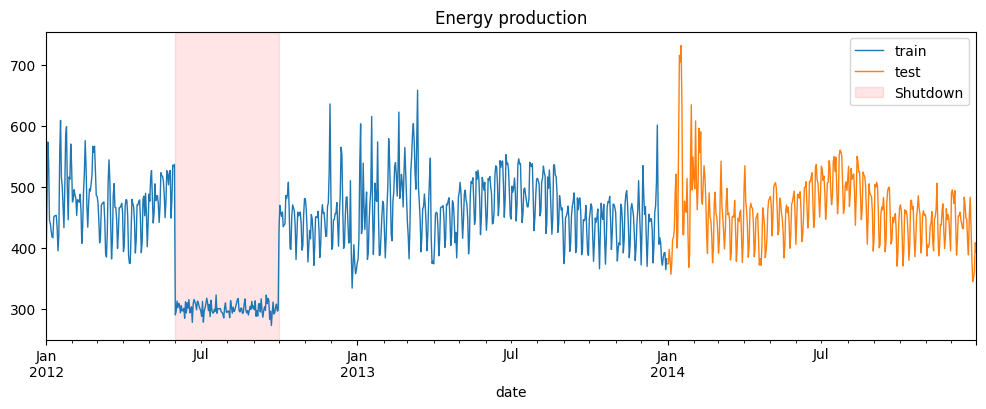

In [35]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_train.production.plot(ax=ax, label='train', linewidth=1)
data_test.production.plot(ax=ax, label='test', linewidth=1)
ax.axvspan(
    pd.to_datetime('2012-06'),
    pd.to_datetime('2012-10'), 
    label="Shutdown",
    color="red",
    alpha=0.1
)
ax.set_title('Energy production')
ax.legend();

## Exclude part of the time series

The factory shutdown took place from 2012-06 to 2012-10. To minimize the influence on the model of these dates, a custom function is created that gives a value of 0 if the index date is within the shutdown period and 1 otherwise. If an observation has a weight of 0, it has no influence at all during model training.

In [37]:
# Custom function to define weights
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is one of '2012-06', '2012-07', '2012-08', '2012-09', '2012-10'
    and return 1 otherwise.
    """
    dates = ['2012-06', '2012-07', '2012-08', '2012-09', '2012-10']
    weights = np.where(
                index.strftime('%Y-%m').isin(dates),
                0,
                1

              )
    return weights

Again, a `ForecasterAutoreg` is trained but this time including the `custom_weights` function.

In [38]:
# Create Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor   = HistGradientBoostingRegressor(random_state=123),
                 lags        = 21,
                 weight_func = custom_weights
             )

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func``.`

In [39]:
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is one of '2012-06', '2012-07', '2012-08', '2012-09', '2012-10'
    and return 1 otherwise.
    """
    dates = ['2012-06', '2012-07', '2012-08', '2012-09', '2012-10']
    weights = np.where(
                index.strftime('%Y-%m').isin(dates),
                0,
                1

              )
    return weights



Once the forecaster is created, a backtesting process is run to simulate its behavior if it had predicted the test set in 12-day batches.

In [43]:
# Backtesting: predict 10 days
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.production,
                                   initial_train_size = len(data.loc[:end_train]),
                                   fixed_train_size   = False,
                                   steps              = 10,
                                   metric             = 'mean_absolute_error',
                                   refit              = False,
                                   verbose            = False
                               )

print(f"Backtest error: {metric}")
predictions_backtest.head()

Backtest error: 28.99273799993966


,pred
2014-01-01,385.713802
2014-01-02,403.594046
2014-01-03,461.091018
2014-01-04,463.456448
2014-01-05,435.432011


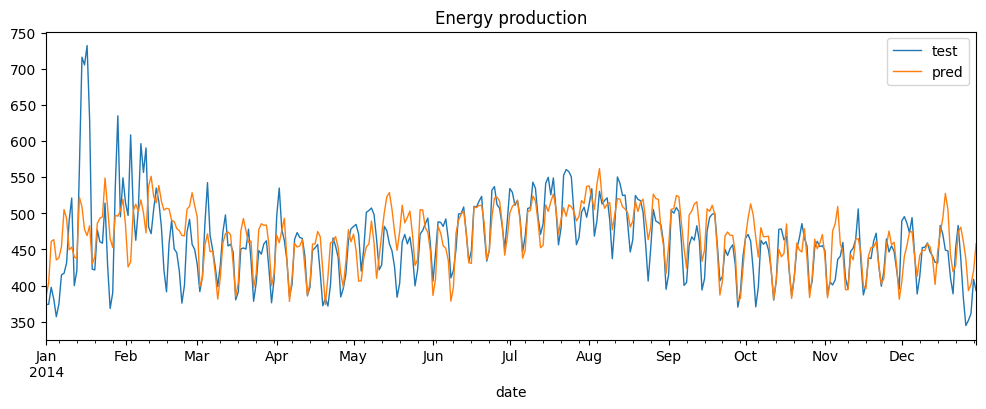

In [44]:
# Predictions plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_test.production.plot(ax=ax, label='test', linewidth=1)
predictions_backtest.plot(ax=ax, label='predictions', linewidth=1)
ax.set_title('Energy production')
ax.legend();

In [32]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>